In [ ]:
from pathlib import Path
import sys
import time
from typing import Tuple

import requests
import numpy as np
import torch
from PIL import Image, ImageOps
import cv2
import io
from typing import Tuple
import torch
import subprocess
import torchvision.transforms as transforms
import os
import shutil

def ffmpeg_suitability(path):
    try:
        version = subprocess.run([path, "-version"], check=True,
                                 capture_output=True).stdout.decode("utf-8")
    except:
        return 0
    score = 0
    #rough layout of the importance of various features
    simple_criterion = [("libvpx", 20),("264",10), ("265",3),
                        ("svtav1",5),("libopus", 1)]
    for criterion in simple_criterion:
        if version.find(criterion[0]) >= 0:
            score += criterion[1]
    #obtain rough compile year from copyright information
    copyright_index = version.find('2000-2')
    if copyright_index >= 0:
        copyright_year = version[copyright_index+6:copyright_index+9]
        if copyright_year.isnumeric():
            score += int(copyright_year)
    return score


ffmpeg_paths = []
try:
    from imageio_ffmpeg import get_ffmpeg_exe
    imageio_ffmpeg_path = get_ffmpeg_exe()
    ffmpeg_paths.append(imageio_ffmpeg_path)
except:
    if "VHS_USE_IMAGEIO_FFMPEG" in os.environ:
        raise
    # logger.warn("Failed to import imageio_ffmpeg")
if "VHS_USE_IMAGEIO_FFMPEG" in os.environ:
    ffmpeg_path = imageio_ffmpeg_path
else:
    system_ffmpeg = shutil.which("ffmpeg")
    if system_ffmpeg is not None:
        ffmpeg_paths.append(system_ffmpeg)
    if os.path.isfile("ffmpeg"):
        ffmpeg_paths.append(os.path.abspath("ffmpeg"))
    if os.path.isfile("ffmpeg.exe"):
        ffmpeg_paths.append(os.path.abspath("ffmpeg.exe"))
    if len(ffmpeg_paths) == 0:
        # logger.error("No valid ffmpeg found.")
        ffmpeg_path = None
    elif len(ffmpeg_paths) == 1:
        #Evaluation of suitability isn't required, can take sole option
        #to reduce startup time
        ffmpeg_path = ffmpeg_paths[0]
    else:
        ffmpeg_path = max(ffmpeg_paths, key=ffmpeg_suitability)
        
def tensor_to_int(tensor, bits):
    tensor = tensor.cpu().numpy() * (2**bits-1)
    return np.clip(tensor, 0, (2**bits-1))

def tensor_to_bytes(tensor):
    return tensor_to_int(tensor, 8).astype(np.uint8)


def ffmpeg_process(args, file_path, env):
    res = None
    frame_data = yield
    total_frames_output = 0
    if res != b'':
        with subprocess.Popen(args + [file_path], stderr=subprocess.PIPE,
                              stdin=subprocess.PIPE, env=env) as proc:
            try:
                while frame_data is not None:
                    proc.stdin.write(frame_data)
                    frame_data = yield
                    total_frames_output+=1
                proc.stdin.flush()
                proc.stdin.close()
                res = proc.stderr.read()
            except BrokenPipeError as e:
                res = proc.stderr.read()
                raise Exception("An error occurred in the ffmpeg subprocess:\n" \
                        + res.decode("utf-8"))
    yield total_frames_output
    if len(res) > 0:
        print(res.decode("utf-8"), end="", file=sys.stderr)

def tensor_to_video_and_back(images, desired_crf=30):
    # Get input shape and create temp directory
    temp_dir = "temp_video"
    filename = f"frame_{time.time()}".split('.')[0]
    os.makedirs(temp_dir, exist_ok=True)
    
    # Convert single image to list if necessary
    if len(images.shape) == 3:
        images = [images]

    first_image = images[0]
    images = iter(images)
    
    has_alpha = first_image.shape[-1] == 4
    print(has_alpha)
    dim_alignment = 8
    if (first_image.shape[1] % dim_alignment) or (first_image.shape[0] % dim_alignment):
        #output frames must be padded
        to_pad = (-first_image.shape[1] % dim_alignment,
                    -first_image.shape[0] % dim_alignment)
        padding = (to_pad[0]//2, to_pad[0] - to_pad[0]//2,
                    to_pad[1]//2, to_pad[1] - to_pad[1]//2)
        padfunc = torch.nn.ReplicationPad2d(padding)
        def pad(image):
            image = image.permute((2,0,1))#HWC to CHW
            padded = padfunc(image.to(dtype=torch.float32))
            return padded.permute((1,2,0))
        # pad single image
        first_image = pad(first_image)
        # images = map(pad, images)
        new_dims = (-first_image.shape[1] % dim_alignment + first_image.shape[1],
                    -first_image.shape[0] % dim_alignment + first_image.shape[0])
        dimensions = f"{new_dims[0]}x{new_dims[1]}"
        # logger.warn("Output images were not of valid resolution and have had padding applied")
    else:
        dimensions = f"{first_image.shape[1]}x{first_image.shape[0]}"
    
    first_image_bytes = tensor_to_bytes(first_image).tobytes()

    # images = map(tensor_to_bytes, images)
    if has_alpha:
        i_pix_fmt = 'rgba'
    else:
        i_pix_fmt = 'rgb24'
    
    bitrate = 10
    frame_rate = 25
    
    args = [ffmpeg_path, "-v", "error", "-f", "rawvideo", "-pix_fmt", i_pix_fmt,
                    "-s", dimensions, "-r", str(frame_rate), "-i", "-"]
                    
    args += [
        "-n", "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        "-crf", str(desired_crf),
        
    ] + ["-b:v", str(bitrate) + "M"]
        
    video_path = str(Path(temp_dir) / f"{filename}.mp4")
    
    env = os.environ.copy()
    output_process = ffmpeg_process(args, video_path, env)
    #Proceed to first yield
    output_process.send(None)
    output_process.send(first_image_bytes)
    try:
        output_process.send(None)  # Signal end of input
        frames_written = next(output_process)  # Get the final yield
    except StopIteration:
        pass
    
    time.sleep(0.5)
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not created at {video_path}")
        
    # now load the video
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise RuntimeError(f"Failed to open video file: {video_path}")
    
    ret, frame = video.read()
    if not ret:
        raise RuntimeError("Failed to read frame from video")
    
    video.release()
    
    try:
        os.remove(video_path)
    except OSError as e:
        print(f"Warning: Could not remove temporary file {video_path}: {e}")
    # convert the frame to a PIL image for ComfyUI
    frame = Image.fromarray(frame)
    return frame
    
    
def pil2tensor(images: Image.Image | list[Image.Image]) -> torch.Tensor:
    """Converts a PIL Image or a list of PIL Images to a tensor."""

    def single_pil2tensor(image: Image.Image) -> torch.Tensor:
        np_image = np.array(image).astype(np.float32) / 255.0
        if np_image.ndim == 2:  # Grayscale
            return torch.from_numpy(np_image).unsqueeze(0)  # (1, H, W)
        else:  # RGB or RGBA
            return torch.from_numpy(np_image).unsqueeze(0)  # (1, H, W, C)

    if isinstance(images, Image.Image):
        return single_pil2tensor(images)
    else:
        return torch.cat([single_pil2tensor(img) for img in images], dim=0)
    
def load(url):
    # get the image from the url
    img = Image.open(requests.get(url, stream=True).raw)
    img = ImageOps.exif_transpose(img)
    return (pil2tensor(img),)

# preview an image
(img, ) = load("https://media.memedeck.xyz/memes/user:08bdc8ed_6015_44f2_9808_7cb54051c666/35c95dfd_b186_4a40_9ef1_ac770f453706.jpeg")



output = tensor_to_video_and_back(img, desired_crf=30)
print(output)
# convert to PIL image
output.show()

Noise (Grain) Level: 0.38882655569328256
Blockiness Level: 1044.3187866210938
Artifact Score: 417.9608105818535
Mapped CRF Value: 21.31600133967453


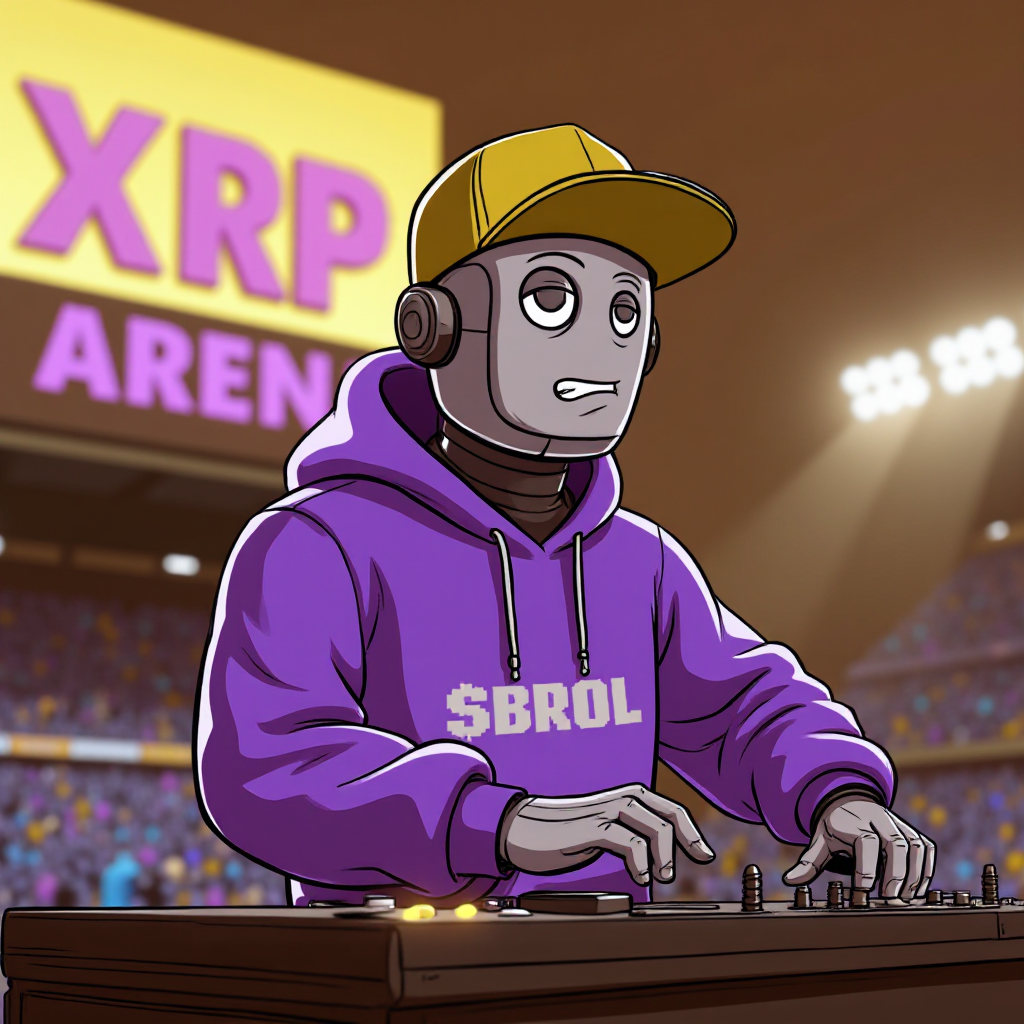

In [8]:
from PIL import Image, ImageOps
import cv2
import numpy as np
from skimage.restoration import estimate_sigma

url = "https://media.memedeck.xyz/memes/user:11322f00_72ba_4fe0_9302_11d71524b437/16f55a83_2a1e_4f37_88d4_551bd32bacc9.jpeg"


# img = Image.open(requests.get(url, stream=True).raw)
# img = ImageOps.exif_transpose(img)

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Noise Estimation (Grain Level)
sigma = estimate_sigma(gray, channel_axis=None)

# Step 2: Blockiness Detection
def calculate_blockiness(img, block_size=8):
    h, w = img.shape
    # Calculate horizontal and vertical differences
    vertical_diff = np.abs(img[:, :-1] - img[:, 1:])
    horizontal_diff = np.abs(img[:-1, :] - img[1:, :])
    
    # Count edges near block boundaries
    vertical_blocks = np.sum(vertical_diff[:, ::block_size])
    horizontal_blocks = np.sum(horizontal_diff[::block_size, :])
    
    # Normalize by the number of blocks
    total_blocks = (h // block_size) * (w // block_size)
    return (vertical_blocks + horizontal_blocks) / total_blocks

blockiness = calculate_blockiness(gray)

# Step 3: Combine Metrics
# Assign weights to grain and blockiness to compute a final score
grain_weight = 0.6
blockiness_weight = 0.4
artifact_score = grain_weight * sigma + blockiness_weight * blockiness

print(f"Noise (Grain) Level: {sigma}")
print(f"Blockiness Level: {blockiness}")
print(f"Artifact Score: {artifact_score}")


artifact_min = 0    # Minimum artifact_score (for near-perfect quality)
artifact_max = 1000 # Maximum artifact_score (for severely compressed images)
crf_min = 0          # CRF for lossless
crf_max = 51         # CRF for worst quality

def map_artifact_to_crf(artifact_score):
    # Normalize artifact_score to the range [0, 1]
    normalized_score = (artifact_score - artifact_min) / (artifact_max - artifact_min)
    normalized_score = max(0, min(1, normalized_score))  # Clamp between 0 and 1

    # Map normalized score to CRF
    crf = crf_min + normalized_score * (crf_max - crf_min)
    return crf

# Example usage
crf_value = map_artifact_to_crf(artifact_score)

# print(f"Artifact Score: {artifact_score}")
print(f"Mapped CRF Value: {crf_value}")
# show image

# convert cv2 image to PIL image
def cv2_to_pil(image):
    return Image.fromarray(image)

# convert PIL image to cv2 image
def pil_to_cv2(image):
    return np.array(image)

# show image
pil_image = cv2_to_pil(image)
pil_image.show()


In [9]:
import cv2
import numpy as np
from skimage.restoration import estimate_sigma

# Define CRF mapping function
artifact_min = 0    # Minimum artifact_score
artifact_max = 1000 # Maximum artifact_score
crf_min = 0         # CRF for lossless
crf_max = 51        # CRF for worst quality

def map_artifact_to_crf(artifact_score):
    # Normalize artifact_score to the range [0, 1]
    normalized_score = (artifact_score - artifact_min) / (artifact_max - artifact_min)
    normalized_score = max(0, min(1, normalized_score))  # Clamp between 0 and 1

    # Map normalized score to CRF
    crf = crf_min + normalized_score * (crf_max - crf_min)
    return crf

# Function to calculate artifact_score
def calculate_artifact_score(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Noise Estimation (Grain Level)
    sigma = estimate_sigma(gray, channel_axis=None)

    # Step 2: Blockiness Detection
    def calculate_blockiness(img, block_size=8):
        h, w = img.shape
        # Calculate horizontal and vertical differences
        vertical_diff = np.abs(img[:, :-1] - img[:, 1:])
        horizontal_diff = np.abs(img[:-1, :] - img[1:, :])
        
        # Count edges near block boundaries
        vertical_blocks = np.sum(vertical_diff[:, ::block_size])
        horizontal_blocks = np.sum(horizontal_diff[::block_size, :])
        
        # Normalize by the number of blocks
        total_blocks = (h // block_size) * (w // block_size)
        return (vertical_blocks + horizontal_blocks) / total_blocks

    blockiness = calculate_blockiness(gray)

    # Step 3: Combine Metrics
    # Assign weights to grain and blockiness to compute a final score
    grain_weight = 0.6
    blockiness_weight = 0.4
    artifact_score = grain_weight * sigma + blockiness_weight * blockiness
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # sigma = estimate_sigma(gray, channel_axis=None)
    # blockiness = np.mean(np.abs(gray[:, :-1] - gray[:, 1:])) + np.mean(np.abs(gray[:-1, :] - gray[1:, :]))
    return artifact_score # Combine noise and blockiness

# Function to dynamically adjust image quality
def adjust_image_to_target_crf(image, target_crf=28):
    current_artifact_score = calculate_artifact_score(image)
    current_crf = map_artifact_to_crf(current_artifact_score)

    print(f"Initial Artifact Score: {current_artifact_score}, Mapped CRF: {current_crf}")

    while abs(current_crf - target_crf) > 1:  # Tolerance of 1 CRF
        if current_crf > target_crf:
            # Reduce artifacts (denoising, deblocking)
            image = cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
            image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
        else:
            # Increase artifacts (slight blurring or noise addition)
            noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
            image = cv2.add(image, noise)

        # Recalculate artifact score and CRF
        current_artifact_score = calculate_artifact_score(image)
        current_crf = map_artifact_to_crf(current_artifact_score)

        print(f"Adjusted Artifact Score: {current_artifact_score}, Mapped CRF: {current_crf}")

    print(f"Final Artifact Score: {current_artifact_score}, Mapped CRF: {current_crf}")
    return image

# Example usage
url = "https://media.memedeck.xyz/memes/user:11322f00_72ba_4fe0_9302_11d71524b437/16f55a83_2a1e_4f37_88d4_551bd32bacc9.jpeg"

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
input_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

adjusted_image = adjust_image_to_target_crf(input_image, target_crf=28)

# convert to PIL image
adjusted_image = Image.fromarray(adjusted_image)
adjusted_image.show()

Initial Artifact Score: 417.9608105818535, Mapped CRF: 21.31600133967453
Adjusted Artifact Score: 824.772296088791, Mapped CRF: 42.06338710052834
Adjusted Artifact Score: 760.9469483174429, Mapped CRF: 38.80829436418959
Adjusted Artifact Score: 722.9093201245329, Mapped CRF: 36.86837532635118
Adjusted Artifact Score: 691.5889075463883, Mapped CRF: 35.271034284865806
Adjusted Artifact Score: 666.7911744113244, Mapped CRF: 34.00634989497755
Adjusted Artifact Score: 627.339668970712, Mapped CRF: 31.99432311750631
Adjusted Artifact Score: 578.4220064778589, Mapped CRF: 29.499522330370805
Adjusted Artifact Score: 509.7047896103197, Mapped CRF: 25.994944270126307
Adjusted Artifact Score: 803.3756391160674, Mapped CRF: 40.97215759491944
Adjusted Artifact Score: 577.4495400946768, Mapped CRF: 29.449926544828514
Adjusted Artifact Score: 393.19234813411276, Mapped CRF: 20.05280975483975
Adjusted Artifact Score: 770.814174740305, Mapped CRF: 39.31152291175555
Adjusted Artifact Score: 266.54960050

KeyboardInterrupt: 

In [3]:
import cv2
import numpy as np
import requests
from io import BytesIO

def load_image_from_url(url):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return image

def calculate_cinematic_score_from_url(image_url):
    # Load image from URL
    image = load_image_from_url(image_url)
    height, width, _ = image.shape
    aspect_ratio = width / height
    
    # 1. Check aspect ratio (e.g., 2.35:1 or similar cinematic ratios)
    aspect_score = 1 if 2.2 <= aspect_ratio <= 2.4 else 0.5 if 1.8 <= aspect_ratio <= 2.2 else 0.2
    
    # 2. Edge clarity (sharpness)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    sharpness_score = np.var(laplacian) / 1000  # Normalized
    
    # 3. Contrast (high dynamic range gives a cinematic feel)
    contrast = image.std()
    contrast_score = min(contrast / 50, 1.0)  # Normalize to [0, 1]
    
    # 4. Color grading similarity (warm or cool tones typical in cinema)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    avg_hue = hsv[:, :, 0].mean()
    cinematic_hue_range = (15, 50)  # Warm tones
    color_score = 1 if cinematic_hue_range[0] <= avg_hue <= cinematic_hue_range[1] else 0.5
    
    # 5. Depth of field (detect blurriness in specific areas)
    focus_map = cv2.Laplacian(gray, cv2.CV_64F)
    focus_var = np.var(focus_map)
    focus_score = min(focus_var / 200, 1.0)  # Normalize
    
    # Combine scores with weights
    total_score = (aspect_score * 0.2 +
                   sharpness_score * 0.2 +
                   contrast_score * 0.2 +
                   color_score * 0.2 +
                   focus_score * 0.2)
    
    return total_score

# Example usage
# image_url = "https://media.memedeck.xyz/memes/user:9381af17_7528_4b1f_9f0f_d2f69431d195/681b9841_8c5d_439a_9d55_00b38c6fbfa6.jpeg" # puppet trump - jitters
# image_url = "https://media.memedeck.xyz/memes/user:08bdc8ed_6015_44f2_9808_7cb54051c666/cd38c163_2ce0_409e_adcb_7e5b8b2316b8.jpeg" # ailu googles - smooth
image_url = "https://media.memedeck.xyz/memes/user:9791687b_53c9_48f3_af34_2f162ae79f30/f9ddd2a9_820d_484e_a66b_f1ea6ec29021.jpeg" # ailu bowser

cinematic_score = calculate_cinematic_score_from_url(image_url)
print(f"Cinematic Score: {cinematic_score:.2f}")

# score of 0.36 maps to crf of 30
# score of 0.54 maps to crf of 28
# score of 0.85 maps to crf of 20
# score of 0.95 maps to crf of 15
# score of 1.0 maps to crf of 10


Cinematic Score: 0.83


/home/holium/ComfyUI/comfy-venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


The image is a cartoon.
None


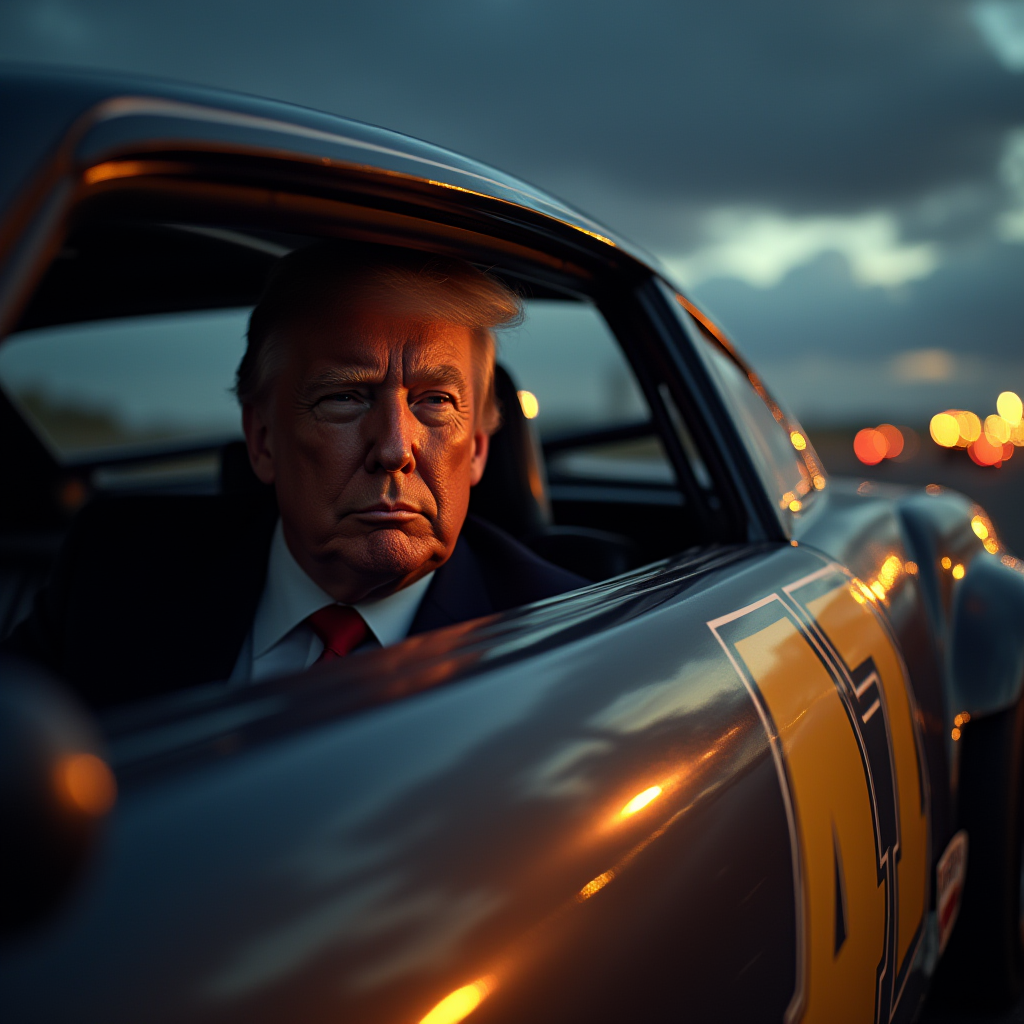

In [12]:
import requests
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image
import torch
from io import BytesIO

# Load the model and feature extractor
model_name = "jayanta/google-vit-base-patch16-224-cartoon-face-recognition"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

def is_cartoon(image):
    # Preprocess the image
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Perform inference
    outputs = model(**inputs)
    logits = outputs.logits

    # Get the predicted class
    predicted_class = torch.argmax(logits, dim=-1).item()

    if predicted_class == 0:
        print("The image is realistic.")
    else:
        print("The image is a cartoon.")

def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image


image = load_image_from_url("https://media.memedeck.xyz/memes/user:9381af17_7528_4b1f_9f0f_d2f69431d195/209a45ff_0b44_4497_960b_eaf826b83dd7.jpeg")
print(is_cartoon(image))
image.show()

In [14]:
# Cartoon or not

from PIL import Image
import requests
from transformers import pipeline

def classify_image_cartoon_or_real(image_path_or_url):
  """
  Classifies an image as either a cartoon or a realistic image using a 
  fast model from the Hugging Face Model Hub.

  Args:
    image_path_or_url: Path to a local image file or a URL to an image.

  Returns:
    A dictionary with the predicted label ("cartoon" or "real") and 
    the confidence score. 
    Returns None if there's an error loading the image.
  """

  try:
    # Load the image (either from a local path or a URL)
    if image_path_or_url.startswith("http"):
      image = Image.open(requests.get(image_path_or_url, stream=True).raw)
    else:
      image = Image.open(image_path_or_url)
  except Exception as e:
    print(f"Error loading image: {e}")
    return None

  # Initialize the image classification pipeline using a fast model
  # We use a distilled version of ViT (Vision Transformer) for speed.
  classifier = pipeline("image-classification", model="sagu7/cartoondetection_sagnik")
  # classifier = pipeline("image-classification", model="TTNVXX/CartoonOrNot")

  # Classify the image
  predictions = classifier(image)

  # Assume the model provides labels like "cartoon," "real," or similar
  # We'll extract the top prediction and map it to our desired output
  top_prediction = predictions[0]
  label = top_prediction["label"]
  score = top_prediction["score"]
  
  print(predictions)

  # Mapping model output to 'cartoon' or 'real'
  if "cartoon" in label.lower() or "anime" in label.lower() or "animation" in label.lower():
      predicted_label = "cartoon"
  else:
      predicted_label = "real"


  return {"label": predicted_label, "score": score}


# Example Usage:
# image_url = "https://media.memedeck.xyz/memes/user:060d8e2b_561c_4a87_af65_4080630b5039/7da7f40f_60ac_4d8a_8a2f_5446fcaa446d.jpeg"  # Example: cartoon image
# image_url = "https://media.memedeck.xyz/memes/user:060d8e2b_561c_4a87_af65_4080630b5039/7da7f40f_60ac_4d8a_8a2f_5446fcaa446d.jpeg"  # Example: 3d image
image_url = "https://media.memedeck.xyz/memes/user:a7b2e012_c28e_42ca_ab56_50ff4f0168ec/6fc22176_aee6_496f_8cec_9aa7facb54d0.jpeg" # Example: realistic trump image
# image_url = "https://media.memedeck.xyz/memes/user:3d1b97ce_eef5_4350_ac75_72c38e98d7c8/9cbba0e7_3527_44d9_b5e7_cdeb4770e271.jpeg" # Example: realistic pyrate image

result = classify_image_cartoon_or_real(image_url)

if result:
  print(f"Image Classification: {result['label']} (Confidence: {result['score']:.4f})")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'person', 'score': 0.95062655210495}, {'label': 'cartoon', 'score': 0.058252740651369095}]
Image Classification: real (Confidence: 0.9506)


In [373]:
import cv2
import numpy as np
import subprocess

import cv2
import numpy as np
import subprocess

def analyze_compression_artifacts(img, width=640, height=640):
    """
    Analyzes an image for potential compression artifacts.

    Args:
        image_path (str): Path to the image file.

    Returns:
        dict: A dictionary containing metrics related to compression artifacts.
    """

    # img = cv2.imread(image_path)
    # resize image to 640x640
    img = cv2.resize(img, (width, height))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate blockiness (common in high compression)
    blockiness = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Edge detection (blurring can indicate compression)
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges) / (gray.shape[0] * gray.shape[1])

    # Color histogram analysis (color banding in low bitrate compression)
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_variation = np.std(hist)

    return {
        "blockiness": blockiness,
        "edge_density": edge_density,
        "color_variation": color_variation
    }

def reencode_image(input_path, output_path, crf):
    """
    Re-encodes an image using FFmpeg with a specified CRF value.

    Args:
        input_path (str): Path to the input image.
        output_path (str): Path to save the re-encoded image.
        crf (int): CRF value for x264 encoding.
    """

    cmd = [
        'ffmpeg', '-i', input_path, 
        '-c:v', 'libx264', '-crf', str(crf), 
        '-preset', 'medium', '-vf', 'format=yuv420p', 
        output_path
    ]
    subprocess.run(cmd)

def calculate_crf(analysis_results, ideal_blockiness, ideal_edge_density, 
                  ideal_color_variation, blockiness_weight, 
                  edge_density_weight, color_variation_weight):
    """
    Calculates the target CRF based on analysis results and weights.
    """

    target_crf = 28 + (blockiness_weight * (analysis_results["blockiness"] - ideal_blockiness)) \
                  + (edge_density_weight * (analysis_results["edge_density"] - ideal_edge_density)) \
                  + (color_variation_weight * (analysis_results["color_variation"] - ideal_color_variation))

    # Clamp CRF to a reasonable range (optional)
    target_crf = max(18, min(35, target_crf))  
    return target_crf


# --- Example Usage ---

def load_image_from_url(url):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return image

# Example usage
# image_url = "https://media.memedeck.xyz/memes/user:060d8e2b_561c_4a87_af65_4080630b5039/7da7f40f_60ac_4d8a_8a2f_5446fcaa446d.jpeg"  # Example: cartoon image
# image_url = "https://media.memedeck.xyz/memes/user:5c91df08_102c_443d_8acb_e527ecc79e92/687cb6ed_a5a9_496f_8e74_419e2bfe8777.jpeg"  # Example: cartoon image
# image_url = "https://media.memedeck.xyz/memes/user:0b6c00ef_c97b_49d2_9b25_f8d05913b354/2f513b47_9ad4_4094_a17d_078228ef72f9.jpeg" # weed bird
# image_url = "https://media.memedeck.xyz/memes/user:de27548a_47af_4143_b292_00545a38848e/d2f3e627_f8a9_4edb_90bb_d0f101189abf.jpeg" # seal cartoon
# image_url = "https://media.memedeck.xyz/memes/user:295b0f79_acc4_4abe_8d84_521683d626a4/bc799cae_ca85_4736_b736_fcc0e63cff08.jpeg" # pepe disney
# image_url = "https://media.memedeck.xyz/memes/user:88c6dba0_0c88_4175_bd19_d57b3c0f3272/d978ad03_87cc_4cd6_bcd7_fe7be2acdc52.jpeg" # flip frog


# image_url = "https://media.memedeck.xyz/memes/user:f4db492f_b6da_48db_8b59_3176f01499de/87d4d637_3b0a_4b95_b6df_9453b0581499.jpeg" # pepe fighting monkey
# image_url = "https://media.memedeck.xyz/memes/user:060d8e2b_561c_4a87_af65_4080630b5039/7da7f40f_60ac_4d8a_8a2f_5446fcaa446d.jpeg"  # Example: 3d image
# image_url = "https://media.memedeck.xyz/memes/user:a7b2e012_c28e_42ca_ab56_50ff4f0168ec/6fc22176_aee6_496f_8cec_9aa7facb54d0.jpeg" # Example: realistic trump image
# image_url = "https://media.memedeck.xyz/memes/user:3d1b97ce_eef5_4350_ac75_72c38e98d7c8/9cbba0e7_3527_44d9_b5e7_cdeb4770e271.jpeg" # Example: realistic pyrate image
# image_url = "https://media.memedeck.xyz/memes/user:72ccd5f6_3287_4c5d_be99_767f86583cbe/17a3a932_864f_4445_b067_9e8eec55aaef.jpeg" # king lion 3d model
# image_url = "https://media.memedeck.xyz/memes/user:d082f619_d433_4d18_9655_89c5b5686170/24e39e8a_0d2f_4e50_ac24_5351ac2d1d31.jpeg" # chili cinematic

# image_url = "https://media.memedeck.xyz/memes/user:3a81194b_5f7b_4662_a2b6_baf8e04ee765/a7dfd698_90fd_4c4f_9d3d_9de688d00aa6.jpeg" # pepe ice cream

# image_url = "https://media.memedeck.xyz/memes/user:11322f00_72ba_4fe0_9302_11d71524b437/2166a472_179c_4de1_a21f_042a284f67c3.jpeg" # brol widescreen - 33
# image_url = "https://media.memedeck.xyz/memes/user:d2532819_74c5_4605_86e0_bd9720434e8c/3077664e_bff5_4507_bbc5_a0e577068dc3.jpeg" # pyrate snow - 28
# image_url = "https://media.memedeck.xyz/memes/user:d2532819_74c5_4605_86e0_bd9720434e8c/db8795fd_4d09_4421_b58a_f8a54b08300c.jpeg" # pyrate sleight

# image_url = "https://media.memedeck.xyz/memes/user:d2532819_74c5_4605_86e0_bd9720434e8c/db8795fd_4d09_4421_b58a_f8a54b08300c.jpeg" # brol widescreen - 33

# image_url = "https://media.memedeck.xyz/memes/user:9c8fdd06_7c9d_4e7c_9256_6bc872b59e48/19728650_4fe6_4c6c_8089_2aa16150f74c.jpeg" # smiley and batman

# image_url = "https://media.memedeck.xyz/memes/user:3e1de21a_9bf5_4cea_8102_9f89d7dfddd0/bed08851_face_4eda_80f3_6dc4218654aa.jpeg" # trump and hoodie

# image_url = "https://media.memedeck.xyz/memes/user:971abeb3_2ca7_483b_9d67_2dbf10ceedc0/38ac7f40_5dd1_4a64_9577_b5d36975a25c.jpeg" # shifu, swirl


# image_url = "https://media.memedeck.xyz/memes/user:d2532819_74c5_4605_86e0_bd9720434e8c/4d248500_9794_4bb8_97fb_08a46ae3f031.jpeg" # pyrate snow - 25
# image_url = "https://media.memedeck.xyz/memes/user:16d617a9_65ca_4c14_b6f3_0b110da95157/2b72cf72_949a_480b_a029_75adebedf4a1.jpeg" # mulan tradwife - 28

# image_url = "https://media.memedeck.xyz/memes/user:3d1b97ce_eef5_4350_ac75_72c38e98d7c8/b6223ca5_7e20_4694_807f_d0583ddf0c2d.jpeg" # pwaty coding
# image_url = "https://media.memedeck.xyz/memes/user:16d617a9_65ca_4c14_b6f3_0b110da95157/39a88767_478c_4263_a2b7_4e8aff14c1ac.jpeg" # mulan tradwife 2

# image_url = "https://media.memedeck.xyz/memes/user:5c91df08_102c_443d_8acb_e527ecc79e92/e37d118f_9984_422b_ba25_7c9ca8befc8b.jpeg" # walr

# image_url = "https://media.memedeck.xyz/memes/user:d082f619_d433_4d18_9655_89c5b5686170/724c5b92_22b6_461f_974e_1b501799b686.jpeg" # chili - inside
# image_url = "https://media.memedeck.xyz/memes/user:4fb0fd29_c3d0_4535_bb4d_e16adbb4a66c/597fdacd_1fd2_482b_8b97_806c4a569902.jpeg" # seal kilimonjoro
# image_url = "https://media.memedeck.xyz/memes/user:2d72c34e_36ad_4245_a3fb_9b347e044552/b5d71734_cc23_4eca_9142_90aa00d89637.jpeg"  # seal army

# image_url = "https://media.memedeck.xyz/memes/user:3b0556a2_20e5_45ab_97fd_2e837e32aabd/26609dd5_d007_43f7_80e4_444bf3a74137.jpeg" # junior pushing rock

# image_url = "https://media.memedeck.xyz/memes/user:0d2accef_afc9_4e7b_9b74_57208c5c2e4a/e84c816c_b02b_41ad_bd76_3fc6f17d713e.jpeg" # apu santa
# image_url = "https://media.memedeck.xyz/memes/user:de27548a_47af_4143_b292_00545a38848e/b8b738a0_28d1_4bc0_9f8b_5ddd6d9c290c.jpeg" # devil seal

# image_url = "https://media.memedeck.xyz/memes/user:97eff3b8_942b_466d_b987_6fc4095eed4a/a4863a16_6c42_451a_a86f_f105d1007fbf.jpeg" # Teletubbies

# image_url = "https://media.memedeck.xyz/memes/user:11322f00_72ba_4fe0_9302_11d71524b437/f91da9e5_a040_4e99_8452_0b36e06e1648.jpeg" # brol coin

# image_url = "https://media.memedeck.xyz/memes/user:2d72c34e_36ad_4245_a3fb_9b347e044552/a1047d2f_e1e0_452e_a4be_dda1f8506ece.jpeg" # devil seal


# baselines
# image_url = "https://media.memedeck.xyz/memes/user:d2532819_74c5_4605_86e0_bd9720434e8c/4d248500_9794_4bb8_97fb_08a46ae3f031.jpeg" # pyrate snow - 25
# image_url = "https://media.memedeck.xyz/memes/user:16d617a9_65ca_4c14_b6f3_0b110da95157/2b72cf72_949a_480b_a029_75adebedf4a1.jpeg" # mulan tradwife - 32
# image_url = "https://media.memedeck.xyz/memes/user:17dab3ec_515d_44c9_ab05_b92f42bd0c47/674917f5_d6d8_46db_8a81_a65afe21d6b3.jpeg" # percy - 29

# 640x640 - target crf 28
# 768x768 - target crf 35

# Ideal baseline values (replace with your actual values)
ideal_blockiness = 600
ideal_edge_density = 12
ideal_color_variation = 10000

# Weights (adjust these through experimentation)
blockiness_weight = -0.007
edge_density_weight = 0.5
color_variation_weight = -0.0001

# load the image with cv2
image = load_image_from_url(image_url)
analysis_results = analyze_compression_artifacts(image, width=640, height=640)
target_crf = calculate_crf(analysis_results, ideal_blockiness, ideal_edge_density, 
                           ideal_color_variation, blockiness_weight, 
                           edge_density_weight, color_variation_weight)

print(analysis_results)
print(f"target_crf: {target_crf}")



{'blockiness': 421.5456965247155, 'edge_density': 11.40091552734375, 'color_variation': 6850.028}
target_crf: 29.26463510479574
